## Data choice

I chose data presented [here](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427)
It is a dataset that contains 3064 T1-weighted contrast-inhanced images from 233 patients with three kinds of brain tumor: meningioma, glioma, and pituitary tumor, each image contains: image, label, tumor border and tumor mask

I have decided to choose this dataset because of its decent size and already cropperd MRIs 

In [1]:
!wget https://figshare.com/ndownloader/articles/1512427/versions/5

--2021-10-21 20:56:14--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 52.48.236.117, 34.246.131.131, 2a05:d018:1f4:d003:4488:2019:e2b7:352, ...
Connecting to figshare.com (figshare.com)|52.48.236.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  27.4MB/s    in 32s     

2021-10-21 20:56:47 (26.6 MB/s) - ‘5’ saved [879501695/879501695]



In [2]:
!unzip 5

Archive:  5
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [ ]:
!unzip brainTumorDataPublic_1-766.zip -d data/
!unzip brainTumorDataPublic_1533-2298.zip -d data/
!unzip brainTumorDataPublic_767-1532.zip -d data/
!unzip brainTumorDataPublic_2299-3064.zip -d data/

In [35]:
from pathlib import Path
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import random_split
import pickle
from torchvision import transforms
import random

datapath = Path("data")
exmple_path = Path("data/140.mat")

picture_size = 256

In [7]:
#visualization functions

def visualize_border(image, border):
    plt.figure()
    plt.imshow(image) 
    plt.plot(border[1::2], border[::2], color = 'w',  linewidth=3)
    plt.show()

def visualize_mask(image, mask):
    mask_transperent = mask.astype(np.float)
    mask_transperent[np.where(mask_transperent < 0.9)] = np.nan

    plt.figure()
    plt.imshow(image) 
    plt.imshow(mask_transperent, cmap='jet', alpha = 0.7) 
    plt.show()

def transperent_mask(mask):
    mask_transperent = mask.astype(np.float)
    mask_transperent[np.where(mask_transperent < 0.9)] = np.nan
    return mask_transperent

def visualize_mask_and_prediction_multilabel(image, mask, prediction):
  fig, ax = plt.subplots(3, 2, figsize=(10,10))

  ax[0][0].set_title(labels[1]+ " class groung truth")
  ax[0][0].imshow(image)
  ax[0][0].imshow(transperent_mask(mask[0]), cmap='jet', alpha = 0.7)

  ax[0][1].set_title(labels[1]+ " class prediction")
  ax[0][1].imshow(image)
  ax[0][1].imshow(transperent_mask(prediction[0]), cmap='jet', alpha = 0.7)

  ax[1][0].set_title(labels[2]+ " class groung truth")
  ax[1][0].imshow(image)
  ax[1][0].imshow(transperent_mask(mask[1]), cmap='jet', alpha = 0.7)

  ax[1][1].set_title(labels[2]+ " class prediction")
  ax[1][1].imshow(image)
  ax[1][1].imshow(transperent_mask(prediction[1]), cmap='jet', alpha = 0.7)

  ax[2][0].set_title(labels[3]+ " class groung truth")
  ax[2][0].imshow(image)
  ax[2][0].imshow(transperent_mask(mask[2]), cmap='jet', alpha = 0.7)

  ax[2][1].set_title(labels[3]+ " class prediction")
  ax[2][1].imshow(image)
  ax[2][1].imshow(transperent_mask(prediction[2]), cmap='jet', alpha = 0.7)

  fig.show()

def visualize_mask_and_prediction_binary(image, mask, prediction):
  fig, ax = plt.subplots(1, 2, figsize=(10,10))
  ax[0][0].set_title("Groung truth")
  ax[0][0].imshow(image)
  ax[0][0].imshow(transperent_mask(mask[0]), cmap='jet', alpha = 0.7)

  ax[0][1].set_title("Prediction")
  ax[0][1].imshow(image)
  ax[0][1].imshow(transperent_mask(prediction[0]), cmap='jet', alpha = 0.7)

  fig.show()

In [ ]:
datapath = Path("data")
for file in os.listdir(datapath):
  f = h5py.File(datapath / file, 'r')
  image = np.array(f['cjdata']['image'])
  if image.shape[0] != 512:  print(file, image.shape)

1203.mat (256, 256)
1074.mat (256, 256)
1075.mat (256, 256)
1072.mat (256, 256)
956.mat (256, 256)
1073.mat (256, 256)
1076.mat (256, 256)
1204.mat (256, 256)
1071.mat (256, 256)
955.mat (256, 256)
957.mat (256, 256)
1207.mat (256, 256)
1206.mat (256, 256)
1070.mat (256, 256)
1205.mat (256, 256)


In [8]:
#labels
f = h5py.File(exmple_path, 'r')
print("Labels:")
for k, v in f.items():
    print(np.array(v))

Labels:
['PID' 'image' 'label' 'tumorBorder' 'tumorMask']


In [9]:
border = np.array(f['cjdata']['tumorBorder'])[0]
image = np.array(f['cjdata']['image'])
mask = np.array(f['cjdata']['tumorMask'])
label = f['cjdata']['label']

In [10]:
image.shape #one dimensional data

(512, 512)

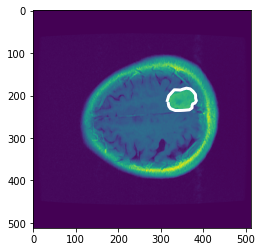

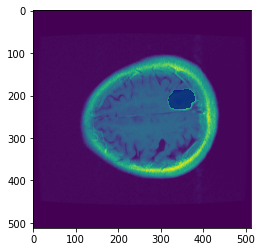

In [11]:
visualize_border(image, border)
visualize_mask(image, mask)

### Creating dataset

In [12]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision.transforms import functional 

In [13]:
def resize_image_and_mask(image, mask, size = picture_size):
  image = functional.resize(image, size)
  mask = functional.resize(mask, size, transforms.InterpolationMode.NEAREST)
  return image, mask

### Binary

In [14]:
#create dataset
class BrainTumorDataset(BaseDataset):    
    def __init__(
            self, 
            data_dir, 
            classes=None, 
            augmentation = None, 
            preprocessing = None,
    ):
        self.data_path = data_dir
        self.ids = os.listdir(data_dir)
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        # self.defaut_transform = 
    
    def __getitem__(self, i):
        totensor = transforms.Compose([transforms.ToTensor()])
        # read data
        f = h5py.File(self.data_path / self.ids[i], 'r')
        
        image = np.array(f['cjdata']['image'])
        # border = np.array(f['cjdata']['tumorBorder'])[0]
        mask = np.array(f['cjdata']['tumorMask'])

        image = torch.Tensor([image])
        mask = torch.Tensor([mask])

        # apply augmentations
        if self.augmentation:
            image = self.augmentation(image)
            mask = self.augmentation(mask)
        
        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image)
            mask = self.preprocessing(mask)

        image, mask = resize_image_and_mask(image, mask)

        return image.float(), mask.float()
        
    def __len__(self):
        return len(self.ids) 

2236


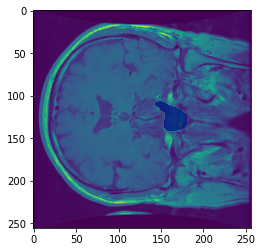

In [15]:
dataset = BrainTumorDataset(datapath)
i = np.random.randint(len(dataset))
print(i)
image, mask = dataset[i]
visualize_mask(image[0].numpy(), mask[0].numpy())

### Multilabel

In [16]:
labels = {
    1: "meningioma",
    2: "glioma",
    3: "pituitary tumor"
}

#create dataset
class BrainTumorDatasetMultilabel(BaseDataset):    
    def __init__(
            self, 
            data_dir, 
            classes=None, 
            augmentation = None, 
            preprocessing = None,
    ):
        self.data_path = data_dir
        self.ids = os.listdir(data_dir)
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        # self.defaut_transform = 
    
    def __getitem__(self, i):
        totensor = transforms.Compose([transforms.ToTensor()])
        # read data
        f = h5py.File(self.data_path / self.ids[i], 'r')
        
        image = np.array(f['cjdata']['image'])
        label = np.array(f['cjdata']['label'])
        mask = np.array(f['cjdata']['tumorMask'])

        target = torch.zeros(len(labels), picture_size, picture_size)

        image = torch.Tensor([image])
        mask = torch.Tensor([mask])

        # apply augmentations
        if self.augmentation:
            image = self.augmentation(image)
            mask = self.augmentation(mask)
        
        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image)
            mask = self.preprocessing(mask)

        image, mask = resize_image_and_mask(image, mask)
        target[label-1] = mask

        return image.float(), target.float()
        
    def __len__(self):
        return len(self.ids) 

42


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


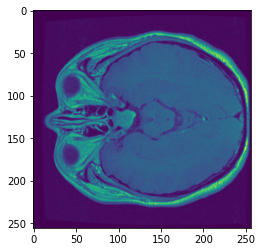

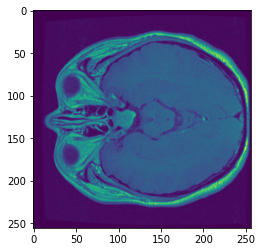

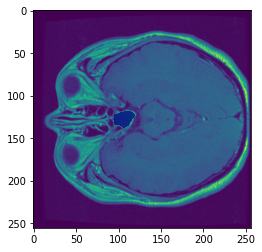

In [17]:
dataset = BrainTumorDatasetMultilabel(datapath)
i = np.random.randint(len(dataset))
print(i)
image, mask = dataset[i]
visualize_mask(image[0].numpy(), mask[0].numpy())
visualize_mask(image[0].numpy(), mask[1].numpy())
visualize_mask(image[0].numpy(), mask[2].numpy())

## Training binary predictors

Models will predict only binary mask witout class

I will use pretrained encoders and models from library segmentation_models_pytorch, cause i do not have resurses to train my own with that accuracy

In [18]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 87 kB 3.3 MB/s 
     |████████████████████████████████| 376 kB 32.1 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=4ebe61a6a7b634f6a179d76a28ba5c971518de94956214d11e522eb5afcc55aa
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=a4f9e19613359f7efb8a0f9855232559d6bb9b0f0bc14c92fb25572a0cecc366
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [19]:
import torch
import segmentation_models_pytorch as smp

### FPN

In [21]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

In [22]:
# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1,
    classes=1, 
    activation=ACTIVATION,
).cuda()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [23]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore()
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [24]:
# ENCODER = 'resnet34'
# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER)

In [25]:
dataset = BrainTumorDataset(datapath)
train_size = int(len(dataset)/10*7)
print("Train size is",train_size,"val size is", len(dataset)-train_size )
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])


with open("binary_train_indices.txt", "wb") as fp:
    pickle.dump(train_dataset.indices, fp)
with open("binary_train_indices.txt", "wb") as fp:
    pickle.dump(train_dataset.indices, fp)

Train size is 2144 val size is 920


In [26]:
#loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
i = np.random.randint(len(dataset))
print(i)
image, mask = dataset[i]
visualize_mask(image[0].numpy(), mask[0].numpy())

In [27]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
)

In [29]:
max_score = 0
train_logs_arr = []
valid_logs_arr = []

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_logs_arr.append(train_logs)
    valid_logs_arr.append(valid_logs)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './binary_fpn_best.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/268 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid: 100%|██████████| 920/920 [02:50<00:00,  5.41it/s, dice_loss - 0.3422, iou_score - 0.5513, accuracy - 0.9913, fscore - 0.6623]
Model saved!

Epoch: 1
valid: 100%|██████████| 920/920 [02:46<00:00,  5.52it/s, dice_loss - 0.2833, iou_score - 0.6165, accuracy - 0.9926, fscore - 0.7219]
Model saved!

Epoch: 2
valid: 100%|██████████| 920/920 [02:52<00:00,  5.34it/s, dice_loss - 0.2617, iou_score - 0.6368, accuracy - 0.9928, fscore - 0.7429]
Model saved!

Epoch: 3
valid: 100%|██████████| 920/920 [02:53<00:00,  5.31it/s, dice_loss - 0.2666, iou_score - 0.6401, accuracy - 0.9941, fscore - 0.736]
Model saved!

Epoch: 4
valid: 100%|██████████| 920/920 [02:48<00:00,  5.47it/s, dice_loss - 0.2498, iou_score - 0.6572, accuracy - 0.9942, fscore - 0.7525]
Model saved!


In [31]:
# model = torch.load("fpn_best.pth")
val_terator = iter(valid_loader)

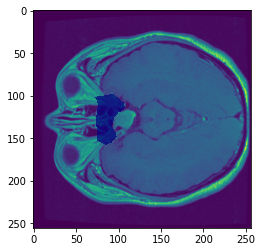

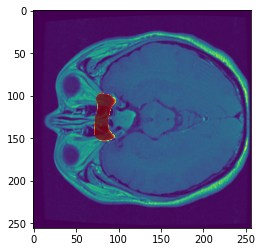

In [32]:
img, mask = next(val_terator)   
res = model.predict(img.cuda())

visualize_mask(image[0].numpy(), mask[0][0].numpy())
visualize_mask(image[0].numpy(), res[0][0].cpu().numpy())

Quite fast training

## DeepLabV3

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

In [ ]:
model = smp.DeepLabV3(    
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1,
    classes=1, 
    activation=ACTIVATION,
).cuda()

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore()
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER)

In [ ]:
dataset = BrainTumorDataset(datapath)
train_size = int(len(dataset)/10*7)
print("Train size is",train_size,"val size is", len(dataset)-train_size )
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])


with open("DeepLabV3_train_indices.txt", "wb") as fp:
    pickle.dump(train_dataset.indices, fp)
with open("DeepLabV3_val_indices.txt", "wb") as fp:
    pickle.dump(train_dataset.indices, fp)

#loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Train size is 2144 val size is 920


In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0
train_logs_arr = []
valid_logs_arr = []

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_logs_arr.append(train_logs)
    valid_logs_arr.append(valid_logs)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './DeepLabV3_best_model.pth')
        print('Model saved!')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.set_title("Loss")
ax1.plot([x['dice_loss'] for x in train_logs_arr], label = "train loss")
ax1.plot([x['dice_loss'] for x in valid_logs_arr], label = "val loss")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.set_title("Iou_score")
ax2.plot([x['iou_score'] for x in train_logs_arr], label = "train iou_score")
ax2.plot([x['iou_score'] for x in valid_logs_arr], label = "val iou_score")
ax2.legend()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

fig.show()

Example of prediction

In [ ]:
model = torch.load("DeepLabV3_best_model.pth")
val_terator = iter(valid_loader)

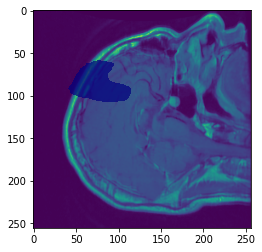

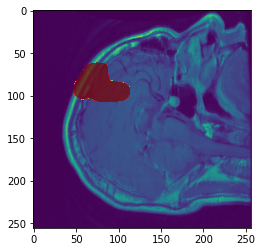

In [ ]:
img, mask = next(val_terator)   
res = model.predict(img.cuda())

visualize_mask(image[0].numpy(), mask[0][0].numpy())
visualize_mask(image[0].numpy(), res[0][0].cpu().numpy())

No so bad, but bot the best result, also very long training

## Training multilabel models

Models that predict in N channels, where N is number or classes

### FPN

In [ ]:
dataset = BrainTumorDatasetMultilabel(datapath)
train_size = int(len(dataset)/10*7)
print("Train size is",train_size,"val size is", len(dataset)-train_size )
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])


with open("BrainTumorDatasetMulticlass_train_indices.txt", "wb") as fp:
    pickle.dump(train_dataset.indices, fp)
with open("BrainTumorDatasetMulticlass_val_indices.txt", "wb") as fp:
    pickle.dump(train_dataset.indices, fp)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Train size is 2144 val size is 920


In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
MODE = smp.losses.constants.MULTILABEL_MODE

In [ ]:
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1,
    classes=3, 
    activation=ACTIVATION,
).cuda()

loss = smp.losses.TverskyLoss(mode = MODE)
loss.__name__ = 'TverskyLoss'
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore()
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
)

max_score = 0
train_logs_arr = []
valid_logs_arr = []

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_logs_arr.append(train_logs)
    valid_logs_arr.append(valid_logs)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './FPN_multilabel_best_model.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 920/920 [02:43<00:00,  5.63it/s, TverskyLoss - 0.3181, iou_score - 0.1125, accuracy - 0.948, fscore - 0.1867]
Model saved!

Epoch: 1
valid: 100%|██████████| 920/920 [02:41<00:00,  5.68it/s, TverskyLoss - 0.3177, iou_score - 0.2047, accuracy - 0.9787, fscore - 0.3178]
Model saved!

Epoch: 2
valid: 100%|██████████| 920/920 [02:42<00:00,  5.66it/s, TverskyLoss - 0.3177, iou_score - 0.2641, accuracy - 0.9851, fscore - 0.3922]
Model saved!

Epoch: 3
valid: 100%|██████████| 920/920 [02:50<00:00,  5.40it/s, TverskyLoss - 0.3176, iou_score - 0.2388, accuracy - 0.9823, fscore - 0.3606]

Epoch: 4
valid: 100%|██████████| 920/920 [02:46<00:00,  5.53it/s, TverskyLoss - 0.3176, iou_score - 0.2751, accuracy - 0.986, fscore - 0.4071]
Model saved!


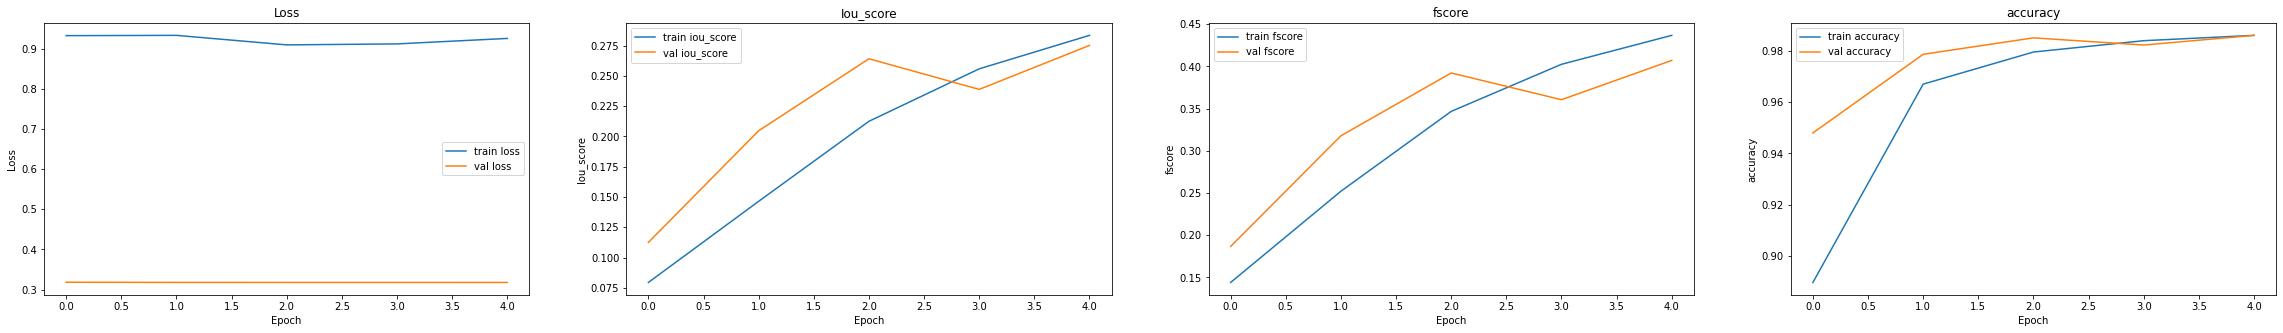

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,5))

ax1.set_title("Loss")
ax1.plot([x['TverskyLoss'] for x in train_logs_arr], label = "train loss")
ax1.plot([x['TverskyLoss'] for x in valid_logs_arr], label = "val loss")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.set_title("Iou_score")
ax2.plot([x['iou_score'] for x in train_logs_arr], label = "train iou_score")
ax2.plot([x['iou_score'] for x in valid_logs_arr], label = "val iou_score")
ax2.legend()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Iou_score")

ax3.set_title("fscore")
ax3.plot([x['fscore'] for x in train_logs_arr], label = "train fscore")
ax3.plot([x['fscore'] for x in valid_logs_arr], label = "val fscore")
ax3.legend()
ax3.set_xlabel("Epoch")
ax3.set_ylabel("fscore")

ax4.set_title("accuracy")
ax4.plot([x['accuracy'] for x in train_logs_arr], label = "train accuracy")
ax4.plot([x['accuracy'] for x in valid_logs_arr], label = "val accuracy")
ax4.legend()
ax4.set_xlabel("Epoch")
ax4.set_ylabel("accuracy")

fig.show()

In [ ]:
# model = torch.load("./FPN_multilabel_best_model.pth")

In [ ]:
val_terator = iter(valid_loader)

PREDICTED CLASS: meningioma


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


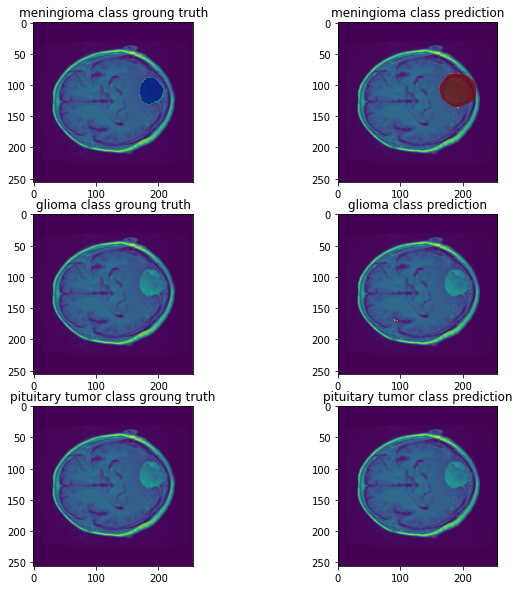

In [ ]:
img, mask = next(val_terator)   
res = model.predict(img.cuda())

#class as argmax + 1
summs_along_channels = torch.sum(res[0], dim=[1,2])
armax = torch.argmax(summs_along_channels).cpu().numpy()
pred_class = labels[armax + 1]
print("PREDICTED CLASS:", pred_class)

visualize_mask_and_prediction_multilabel(img[0][0].numpy(), mask[0].numpy(), res[0].cpu().numpy())

### DeepLabv3

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
MODE = smp.losses.constants.MULTILABEL_MODE

In [ ]:
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1,
    classes=3, 
    activation=ACTIVATION,
).cuda()

loss = smp.losses.DiceLoss(mode = MODE)
loss.__name__ = 'DiceLoss'
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore()
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
)

max_score = 0
train_logs_arr = []
valid_logs_arr = []

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_logs_arr.append(train_logs)
    valid_logs_arr.append(valid_logs)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './deeplabv3_multilabel_best_model.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 920/920 [02:49<00:00,  5.44it/s, DiceLoss - 0.3185, iou_score - 0.09759, accuracy - 0.9454, fscore - 0.1712]
Model saved!

Epoch: 1
valid: 100%|██████████| 920/920 [02:49<00:00,  5.42it/s, DiceLoss - 0.3179, iou_score - 0.2071, accuracy - 0.979, fscore - 0.324]
Model saved!

Epoch: 2
valid: 100%|██████████| 920/920 [02:49<00:00,  5.43it/s, DiceLoss - 0.3177, iou_score - 0.2985, accuracy - 0.9863, fscore - 0.4338]
Model saved!

Epoch: 3
valid: 100%|██████████| 920/920 [02:50<00:00,  5.40it/s, DiceLoss - 0.3176, iou_score - 0.298, accuracy - 0.9871, fscore - 0.4381]

Epoch: 4
valid: 100%|██████████| 920/920 [02:48<00:00,  5.45it/s, DiceLoss - 0.3176, iou_score - 0.3156, accuracy - 0.9877, fscore - 0.4524]
Model saved!


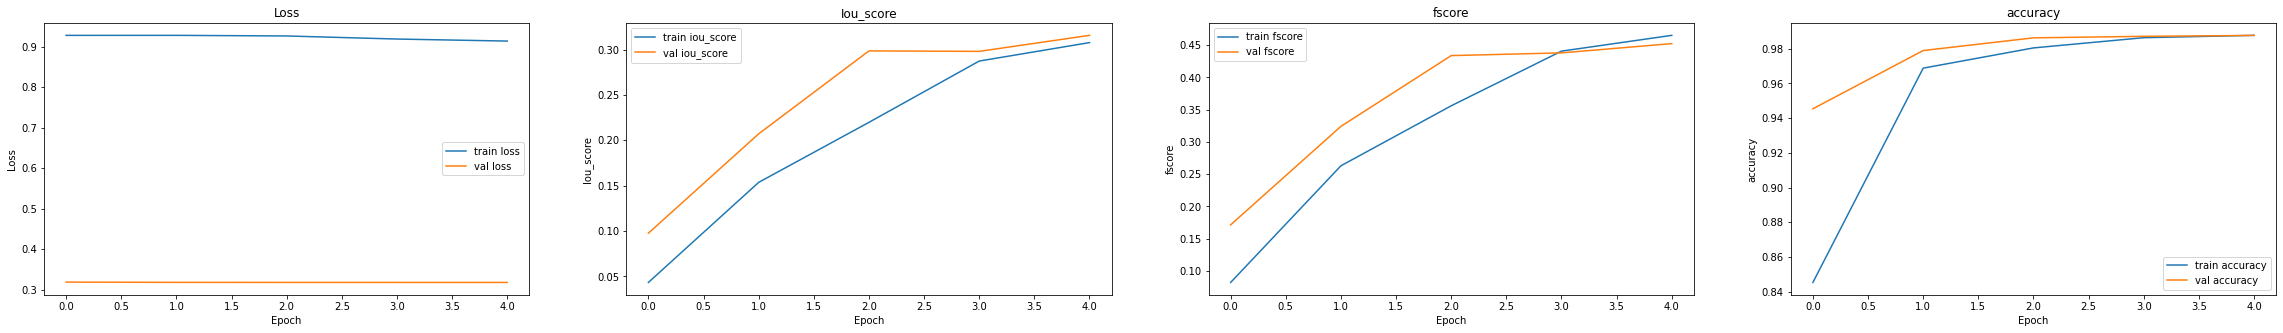

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,5))

ax1.set_title("Loss")
ax1.plot([x['DiceLoss'] for x in train_logs_arr], label = "train loss")
ax1.plot([x['DiceLoss'] for x in valid_logs_arr], label = "val loss")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.set_title("Iou_score")
ax2.plot([x['iou_score'] for x in train_logs_arr], label = "train iou_score")
ax2.plot([x['iou_score'] for x in valid_logs_arr], label = "val iou_score")
ax2.legend()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Iou_score")

ax3.set_title("fscore")
ax3.plot([x['fscore'] for x in train_logs_arr], label = "train fscore")
ax3.plot([x['fscore'] for x in valid_logs_arr], label = "val fscore")
ax3.legend()
ax3.set_xlabel("Epoch")
ax3.set_ylabel("fscore")

ax4.set_title("accuracy")
ax4.plot([x['accuracy'] for x in train_logs_arr], label = "train accuracy")
ax4.plot([x['accuracy'] for x in valid_logs_arr], label = "val accuracy")
ax4.legend()
ax4.set_xlabel("Epoch")
ax4.set_ylabel("accuracy")

fig.show()

In [ ]:
val_terator = iter(valid_loader)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


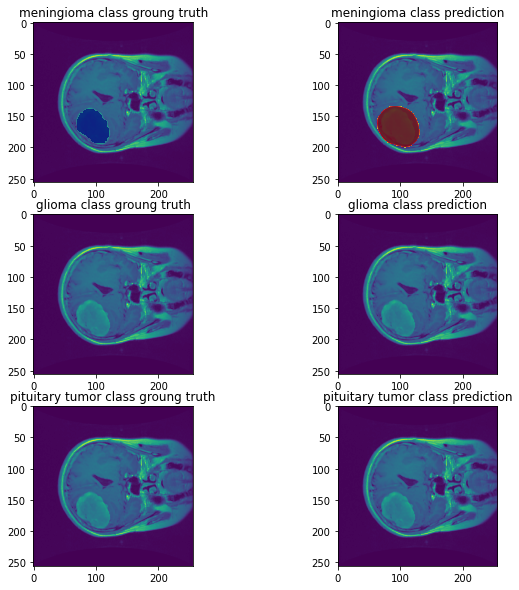

In [ ]:
img, mask = next(val_terator)   
res = model.predict(img.cuda())
visualize_mask_and_prediction_multilabel(img[0][0].numpy(), mask[0].numpy(), res[0].cpu().numpy())

### PAN

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
MODE = smp.losses.constants.MULTILABEL_MODE

In [ ]:
model = smp.PAN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1,
    classes=3, 
    activation=ACTIVATION,
).cuda()

loss = smp.losses.DiceLoss(mode = MODE)
loss.__name__ = 'DiceLoss'
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore()
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
)

max_score = 0
train_logs_arr = []
valid_logs_arr = []

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_logs_arr.append(train_logs)
    valid_logs_arr.append(valid_logs)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './pan_multilabel_best_model.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 920/920 [02:12<00:00,  6.92it/s, DiceLoss - 0.3182, iou_score - 0.1897, accuracy - 0.9737, fscore - 0.2966]
Model saved!

Epoch: 1
valid: 100%|██████████| 920/920 [02:13<00:00,  6.91it/s, DiceLoss - 0.3177, iou_score - 0.2361, accuracy - 0.98, fscore - 0.3615]
Model saved!

Epoch: 2
valid: 100%|██████████| 920/920 [02:12<00:00,  6.93it/s, DiceLoss - 0.3177, iou_score - 0.2639, accuracy - 0.9847, fscore - 0.3954]
Model saved!

Epoch: 3
valid: 100%|██████████| 920/920 [02:09<00:00,  7.08it/s, DiceLoss - 0.3176, iou_score - 0.2645, accuracy - 0.984, fscore - 0.3974]
Model saved!

Epoch: 4
train:  77%|███████▋  | 206/268 [03:47<01:08,  1.10s/it, DiceLoss - 0.9209, iou_score - 0.3189, accuracy - 0.9879, fscore - 0.4775]

As can be seen for multi label segmentation all of these neteorks are very similar after 5 epochs with same encoder, but PAN works faster and has best metrics so I will try to tune it a lottle bit more 

### Model tuning 

In [48]:
dataset = BrainTumorDatasetMultilabel(datapath)
train_size = int(len(dataset)/10*7)
print("Train size is",train_size,"val size is", len(dataset)-train_size )
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])


with open("BrainTumorDatasetMulticlass_train_indices_final.txt", "wb") as fp:
    pickle.dump(train_dataset.indices, fp)
with open("BrainTumorDatasetMulticlass_val_indices_final.txt", "wb") as fp:
    pickle.dump(train_dataset.indices, fp)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Train size is 2144 val size is 920


In [50]:
def show_plots(train_logs_arr, valid_logs_arr):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,5))

  ax1.set_title("Loss")
  ax1.plot([x['Loss'] for x in train_logs_arr], label = "train loss")
  ax1.plot([x['Loss'] for x in valid_logs_arr], label = "val loss")
  ax1.legend()
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")

  ax2.set_title("Iou_score")
  ax2.plot([x['iou_score'] for x in train_logs_arr], label = "train iou_score")
  ax2.plot([x['iou_score'] for x in valid_logs_arr], label = "val iou_score")
  ax2.legend()
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Iou_score")

  ax3.set_title("fscore")
  ax3.plot([x['fscore'] for x in train_logs_arr], label = "train fscore")
  ax3.plot([x['fscore'] for x in valid_logs_arr], label = "val fscore")
  ax3.legend()
  ax3.set_xlabel("Epoch")
  ax3.set_ylabel("fscore")

  ax4.set_title("accuracy")
  ax4.plot([x['accuracy'] for x in train_logs_arr], label = "train accuracy")
  ax4.plot([x['accuracy'] for x in valid_logs_arr], label = "val accuracy")
  ax4.legend()
  ax4.set_xlabel("Epoch")
  ax4.set_ylabel("accuracy")

  fig.show()

In [56]:
ENCODERS = ['se_resnext50_32x4d', "resnet50"]
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
#**"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**, **callable** and **None**
DEVICE = 'cuda'
MODE = smp.losses.constants.MULTILABEL_MODE
LOSSES = {'JaccardLoss' : smp.losses.JaccardLoss,
          'DiceLoss' : smp.losses.DiceLoss, 
          'TverskyLoss' : smp.losses.TverskyLoss, 
          'FocalLoss' : smp.losses.FocalLoss, 
          'LovaszLoss' : smp.losses.LovaszLoss} #all available for multilabel
LRS = [0.0001, 1e-2, 1e-6]
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore()
]

In [ ]:
for i in range(5):
  encoder = random.choice(ENCODERS)

  loss_name = random.choice(list(LOSSES.keys()))
  loss = LOSSES[loss_name](mode = MODE)
  loss.__name__ = "Loss"  

  lr = random.choice(LRS)

  print("Parametrs: LR = " + str(lr) + ", loss is " + loss_name + ", encoder is " + encoder)

  model = smp.PAN(
    encoder_name=encoder, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1,
    classes=3, 
    activation=ACTIVATION,
  ).cuda()
  

  optimizer = torch.optim.Adam([ 
      dict(params=model.parameters(), lr=lr),
  ])
  
  train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
  )

  max_score = 0
  train_logs_arr = []
  valid_logs_arr = []

  for j in range(0, 10):
    
    print('\nEpoch: {}'.format(j))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_logs_arr.append(train_logs)
    valid_logs_arr.append(valid_logs)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './PAN_multilabel_final' + str(i)+'.pth')
        print('Model saved!')
    show_plots(train_logs_arr, valid_logs_arr)